In [271]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error #, accuracy_score ,f1_score,confusion_matrix, classification_report
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

In [272]:

#========================================================== Helper Functions ========================================================================

def remove_value(data, column_name, string_to_replace, replace_value='', change_dataType=True):
  data[column_name] = data[column_name].str.replace(string_to_replace, replace_value)
  if change_dataType:
    data[column_name] = data[column_name].astype(int)

def Feature_Encoder(X, cols):
    encoders = {}
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
        encoders[c] = lbl
    return X, encoders


# Extract number from string
def extract_number(number_string, mode_value=0):
    if isinstance(number_string, str):
        match = re.search(r'\d+', number_string)  # Find the first occurrence of one or more digits
        if match:
            return int(match.group())  # Convert the matched digits to an integer
        else:
            return mode_value  # If no digits found, return 0
    else:
        return number_string


def featureScaling(X, a, b):
    X = np.array(X)
    Normalized_X = np.zeros((X.shape[0], X.shape[1]))
    for i in range(X.shape[1]):
        Normalized_X[:, i] = ((X[:, i] - min(X[:, i])) / (max(X[:, i]) - min(X[:, i]))) * (b - a) + a
    return Normalized_X

def execute_model(model, X_train, Y_train, X_test, Y_test, model_name):
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(Y_train, Y_train_pred)
    print(f"{model_name}:\n Training MSE: {train_mse}")

    test_mse = mean_squared_error(Y_test, Y_test_pred)
    print(f" Testing MSE: {test_mse}")

    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f" Training Accuracy: {train_accuracy}")
    print(f" Testing Accuracy: {test_accuracy}")
    draw(Y_test, Y_test_pred, model_name)

def draw(Y_test, Y_test_pred, model_name):

    plt.figure
    plt.subplot(2,1,1)
    plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual')

    plt.subplot(2,1,2)
    plt.scatter(range(len(Y_test_pred)), Y_test_pred, color='red', label=model_name)

    plt.xlabel('Data Points')
    plt.ylabel('Target Variable')
    plt.title('Regression Model Predictions')
    plt.legend()
    plt.show()




In [273]:
#========================================================== Read Data ========================================================================
data = pd.read_csv('/content/ElecDeviceRatingPrediction_Milestone2.csv')
# print(data.head())


In [274]:
#========================================================= Preprocessing ========================================================================

# Calculate mode for each column
mode_values = data.mode()

mode_dict = {}

for col in mode_values.columns:
    mode_dict[col] = mode_values[col][0]

print(mode_dict)

{'brand': 'ASUS', 'processor_brand': 'Intel', 'processor_name': 'Core i5', 'processor_gnrtn': '11th', 'ram_gb': '8 GB', 'ram_type': 'DDR4', 'ssd': '512 GB', 'hdd': '0 GB', 'os': '64-bit Windows', 'graphic_card_gb': '0 GB', 'weight': 'Casual', 'warranty': '1 year', 'Touchscreen': 'No', 'msoffice': 'No', 'Price': 64990, 'rating': 'Good Rating', 'Number of Ratings': 0, 'Number of Reviews': 0}


In [275]:
# Null Values
print(data.isna().sum())



brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64


In [276]:
# processor_gnrtn
data['processor_gnrtn'].value_counts()
mode_value = data['processor_gnrtn'].mode()[0]
data['processor_gnrtn'].replace('Not Available', mode_value, inplace = True)
remove_value(data, 'processor_gnrtn', 'th')



In [277]:
# ram_gb
remove_value(data,'ram_gb' ,' GB')



In [278]:
# ssd
remove_value(data,'ssd' ,' GB')



In [279]:
# hdd
remove_value(data,'hdd' ,' GB')



In [280]:
# os
data[['os_bits', 'os_type']] = data['os'].str.split(' ', expand=True)
data = data.drop('os', axis = 1)
print('os_bits', ":", data['os_bits'].unique())
print('os_type', ":", data['os_type'].unique())
remove_value(data,'os_bits' ,'-bit')



os_bits : ['64-bit' '32-bit']
os_type : ['Windows' 'DOS' 'Mac']


In [281]:
# graphic_card_gb
remove_value(data,'graphic_card_gb' ,' GB')



In [282]:
# warranty
remove_value(data,'warranty' ,'No warranty', '0', False)
remove_value(data,'warranty' ,' years', '', False)
remove_value(data,'warranty' ,' year')



In [283]:
# Touchscreen
remove_value(data,'Touchscreen' ,'No', '0', False)
remove_value(data,'Touchscreen' ,'Yes', '1')



In [284]:
# msoffice
remove_value(data,'msoffice' ,'No', '0', False)
remove_value(data,'msoffice' ,'Yes', '1')



In [285]:
# rating
rating_performance_mapping = {
    'Bad Rating': 0,
    'Good Rating': 1
}

data['rating'] = data['rating'].map(rating_performance_mapping)




In [286]:
# ram_type
ram_performance_mapping = {
    'LPDDR4X': 5,
    'LPDDR4': 4,
    'DDR4': 3,
    'DDR3': 2,
    'DDR5': 6,
    'LPDDR3': 1
}

data['ram_type'] = data['ram_type'].map(ram_performance_mapping)
# data['ram_type'].value_counts()



In [287]:
# weight
weight = {
    'Casual':2,
    'ThinNlight':1,
    'Gaming':3,
}
data['weight'] = data['weight'].map(weight)



In [288]:
# brand , processor_name
encode_cols = ('brand', 'processor_name')
data, encoders = Feature_Encoder(data, encode_cols)



In [289]:
one_hot_encoders = {}

In [290]:
# processor_brand
one_hot_encoded = pd.get_dummies(data['processor_brand'])
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoders['processor_brand'] = one_hot_encoded

data = data.drop('processor_brand', axis = 1)
data = pd.concat([data, one_hot_encoded], axis=1)



In [291]:
# os_type
one_hot_encoded = pd.get_dummies(data['os_type'])
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoders['os_type'] = one_hot_encoded

data = data.drop('os_type', axis = 1)
data = pd.concat([data, one_hot_encoded], axis=1)



In [292]:
# Replace target column
rating_col = data['rating']
data = data.drop('rating', axis = 1)
data = pd.concat([data, rating_col], axis=1)



lower_bound = {'brand': -5.0, 'processor_name': -2.5, 'processor_gnrtn': 8.5, 'ram_gb': -2.0, 'ram_type': 3.0, 'ssd': -128.0, 'hdd': -768.0, 'graphic_card_gb': -3.0, 'weight': -0.5, 'warranty': -1.5, 'Touchscreen': 0.0, 'msoffice': -1.5, 'Price': -19869.0, 'Number of Ratings': -231.0, 'Number of Reviews': -29.25, 'os_bits': 64.0, 'AMD': 0.0, 'Intel': -1.5, 'M1': 0.0, 'DOS': 0.0, 'Mac': 0.0, 'Windows': 1.0}
upper_bound = {'brand': 11.0, 'processor_name': 9.5, 'processor_gnrtn': 12.5, 'ram_gb': 14.0, 'ram_type': 3.0, 'ssd': 896.0, 'hdd': 1280.0, 'graphic_card_gb': 5.0, 'weight': 3.5, 'warranty': 2.5, 'Touchscreen': 0.0, 'msoffice': 2.5, 'Price': 155675.0, 'Number of Ratings': 385.0, 'Number of Reviews': 48.75, 'os_bits': 64.0, 'AMD': 0.0, 'Intel': 2.5, 'M1': 0.0, 'DOS': 0.0, 'Mac': 0.0, 'Windows': 1.0}


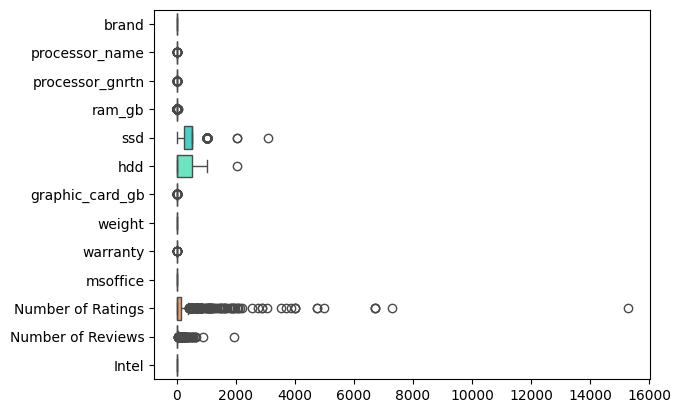

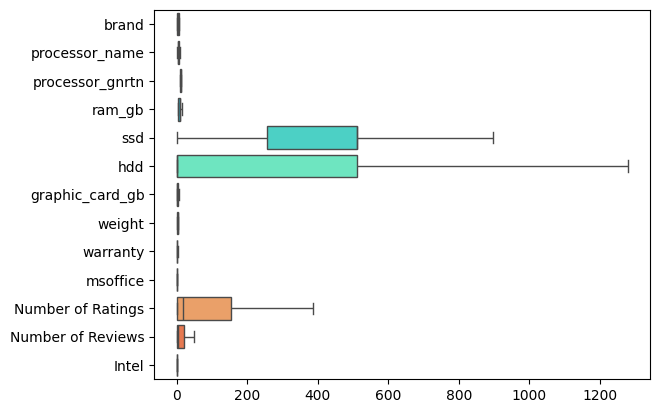

In [293]:
#================================================================ Outliers =======================================================================

columns_to_exclude = ['ram_type', 'Touchscreen', 'os_bits', 'AMD', 'M1', 'DOS', 'Mac', 'Windows', 'rating','Price']
data_filtered = data.drop(columns=columns_to_exclude)

# Create the box plot with the modified data
sns.boxplot(data=data_filtered, palette='rainbow', orient='h')

Q1 = data.iloc[:,:-1].quantile(0.25)
Q3 = data.iloc[:,:-1].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

s = ['ram_type' ,'Touchscreen', 'os_bits' , 'AMD' , 'M1' , 'DOS' , 'Mac' , 'Windows' ]

# Replace the outliers with lower_bound or upper_bound values
for col in data.iloc[:,:-1]:
    if col not in s:
        data.loc[data[col] < lower_bound[col], col] = lower_bound[col]
        data.loc[data[col] > upper_bound[col], col] = upper_bound[col]

# sns.boxplot(data=data,palette='rainbow',orient='h')
data_filtered = data.drop(columns=columns_to_exclude)

plt.figure()
# Create the box plot with the modified data
sns.boxplot(data=data_filtered, palette='rainbow', orient='h')

print(f"lower_bound = {dict(lower_bound)}")
print(f"upper_bound = {dict(upper_bound)}")


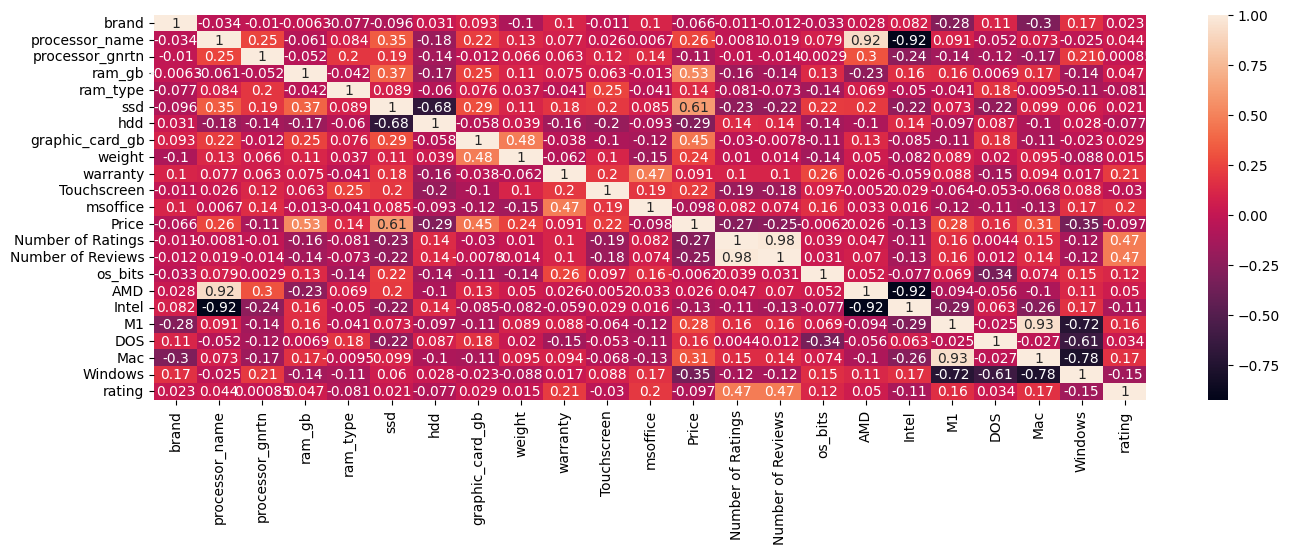

rating               1.000000
Number of Reviews    0.469883
Number of Ratings    0.469399
warranty             0.214187
msoffice             0.200001
Mac                  0.166976
M1                   0.155857
os_bits              0.118402
AMD                  0.049768
ram_gb               0.046712
processor_name       0.043981
DOS                  0.033601
graphic_card_gb      0.029356
brand                0.022819
ssd                  0.021247
weight               0.014623
processor_gnrtn      0.000854
Touchscreen         -0.029731
hdd                 -0.076796
ram_type            -0.081284
Price               -0.096768
Intel               -0.107747
Windows             -0.153616
Name: rating, dtype: float64
Top features:  Index(['warranty', 'msoffice', 'Number of Ratings', 'Number of Reviews',
       'os_bits', 'Intel', 'M1', 'Mac', 'Windows', 'rating'],
      dtype='object')


In [294]:
# ========================================================== Feature selection =========================================================================

corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

print(corr_matrix["rating"].sort_values(ascending=False))

top_feature = corr_matrix.index[abs(corr_matrix['rating']) > 0.1]
print("Top features: ", top_feature)



In [295]:
#==================================================================================================================================================

print("Features after preprocessing:\n")
for col in data.columns:
  if(col == "Price" or col == "Number of Ratings" or col == "Number of Reviews"):
    continue
  print(col, ":", data[col].unique(), data[col].dtype)



Features after preprocessing:

brand : [1 5 4 0 3 7 6 2] int64
processor_name : [6.  2.  0.  1.  9.  5.  8.  3.  7.  9.5 4. ] float64
processor_gnrtn : [11.  10.   8.5 12.   9. ] float64
ram_gb : [ 4  8 14] int64
ram_type : [5 4 3 2 6 1] int64
ssd : [  0 256 512 896 128] int64
hdd : [ 512    0 1024 1280] int64
graphic_card_gb : [0 4 2 5] int64
weight : [2. 1. 3.] float64
warranty : [0.  1.  2.5 2. ] float64
Touchscreen : [0 1] int64
msoffice : [0. 1.] float64
os_bits : [64 32] int64
AMD : [0 1] int64
Intel : [1. 0.] float64
M1 : [0 1] int64
DOS : [0 1] int64
Mac : [0 1] int64
Windows : [1 0] int64
rating : [0 1] int64


In [296]:
# ========================================================== Splitting Data ================================================================

# Split Data
X = data.iloc[:, :-1]
Y = data['rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=70)



In [297]:
# ========================================================== Feature Selection -- Chi-Squared ================================================================
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=22)
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

selected_indices =  selector.get_support(indices=True)
print(selected_indices)
print("Selected features names:", data.columns[selected_indices])

X_train = X_train.iloc[:, selected_indices]
X_test = X_test.iloc[:, selected_indices]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Selected features names: Index(['brand', 'processor_name', 'processor_gnrtn', 'ram_gb', 'ram_type',
       'ssd', 'hdd', 'graphic_card_gb', 'weight', 'warranty', 'Touchscreen',
       'msoffice', 'Price', 'Number of Ratings', 'Number of Reviews',
       'os_bits', 'AMD', 'Intel', 'M1', 'DOS', 'Mac', 'Windows'],
      dtype='object')


Logistic Regression:
 Training MSE: 0.23529411764705882
 Testing MSE: 0.19310344827586207
 Training Accuracy: 0.7647058823529411
 Testing Accuracy: 0.8068965517241379


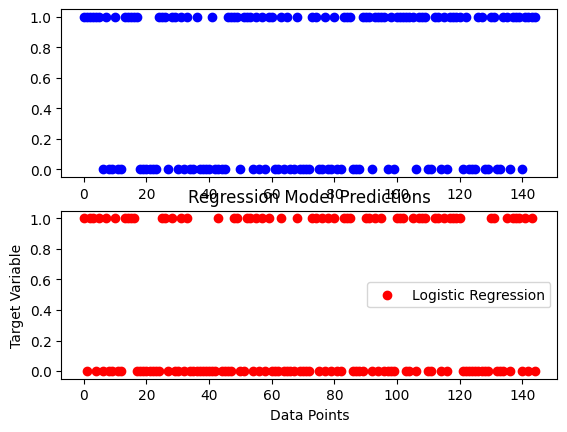

In [298]:
# ========================== Logisitc Regression ==================================

logistic_regression_model = linear_model.LogisticRegression()
execute_model(logistic_regression_model, X_train, Y_train, X_test, Y_test, "Logistic Regression")



SVM:
 Training MSE: 0.43252595155709345
 Testing MSE: 0.35172413793103446
 Training Accuracy: 0.5674740484429066
 Testing Accuracy: 0.6482758620689655


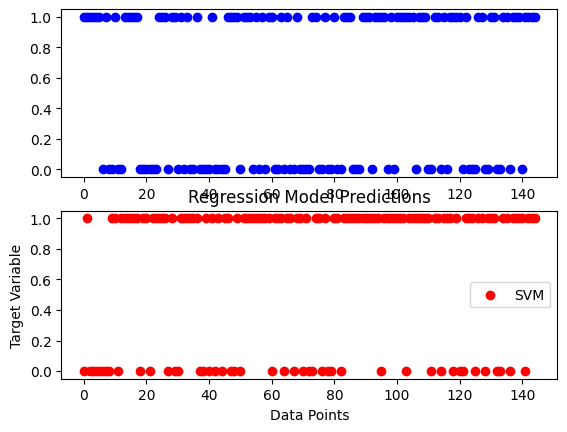

In [299]:
# ======================= SVM =================================
from sklearn import svm
svm_model = svm.SVC()
execute_model(svm_model, X_train, Y_train, X_test, Y_test, "SVM")


Decision Tree Classifier:
 Training MSE: 0.0726643598615917
 Testing MSE: 0.10344827586206896
 Training Accuracy: 0.9273356401384083
 Testing Accuracy: 0.896551724137931


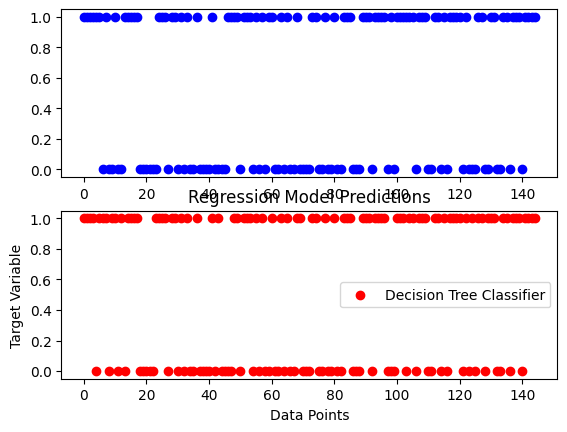

In [300]:
# ========================== Decision Tree =======================================
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(max_depth=5)
execute_model(decision_tree_model, X_train, Y_train, X_test, Y_test, "Decision Tree Classifier")

KNN:
 Training MSE: 0.16608996539792387
 Testing MSE: 0.33793103448275863
 Training Accuracy: 0.8339100346020761
 Testing Accuracy: 0.6620689655172414


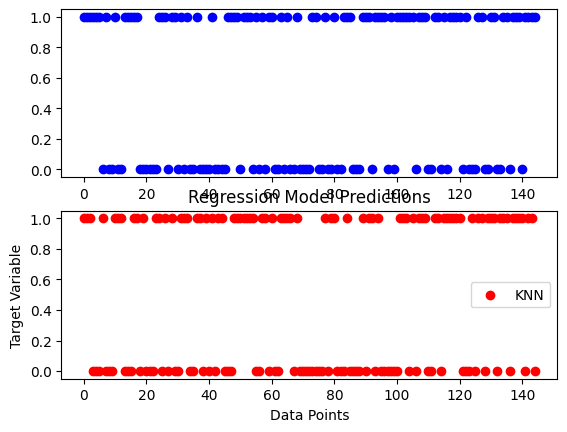

In [301]:
# ========================== KNN =======================================

knn_model = KNeighborsClassifier(n_neighbors=3)

execute_model(knn_model, X_train, Y_train, X_test, Y_test, "KNN")


Random Forest:
 Training MSE: 0.1643598615916955
 Testing MSE: 0.12413793103448276
 Training Accuracy: 0.8356401384083045
 Testing Accuracy: 0.8758620689655172


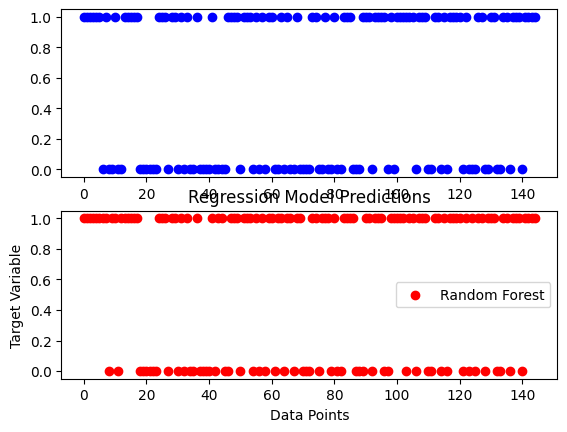

In [302]:
# ========================== Random Forest =======================================

random_forest_model = RandomForestClassifier(max_depth =  2, n_estimators = 3)
execute_model(random_forest_model, X_train, Y_train, X_test, Y_test, "Random Forest")

XGBoost:
 Training MSE: 0.44982698961937717
 Testing MSE: 0.4413793103448276
 Training Accuracy: 0.5501730103806228
 Testing Accuracy: 0.5586206896551724


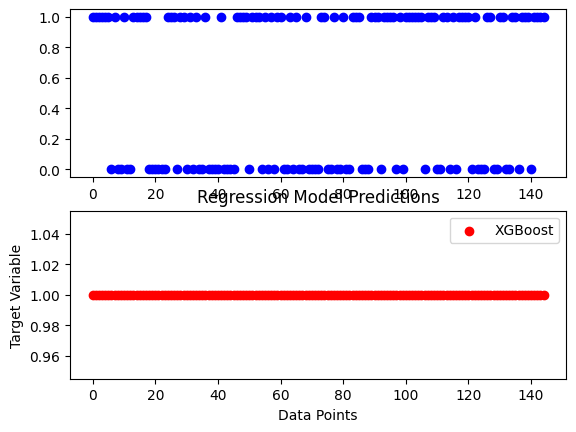

In [303]:
# ========================== XGBoost =======================================

XGBoost_model = XGBClassifier(learning_rate =  0.01, max_depth =  2, n_estimators = 2)
execute_model(XGBoost_model, X_train, Y_train, X_test, Y_test, "XGBoost")

ensemble voting:
 Training MSE: 0.11072664359861592
 Testing MSE: 0.1103448275862069
 Training Accuracy: 0.889273356401384
 Testing Accuracy: 0.8896551724137931


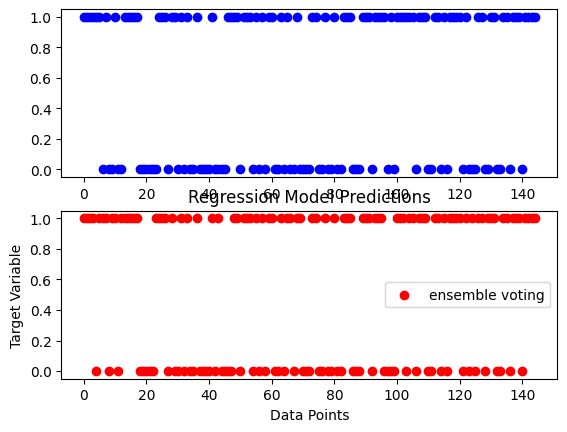

In [304]:
# ========================== Ensemble Learning - Voting =======================================
from sklearn.ensemble import VotingClassifier

ensemble_voting_model=VotingClassifier(estimators= [('KNN', knn_model), ('Random Forest', random_forest_model),('XGBoost',XGBoost_model),('Logistic',logistic_regression_model), ('SVM', svm_model), ('Decision Tree', decision_tree_model)],  voting='hard')
execute_model(ensemble_voting_model, X_train, Y_train, X_test, Y_test, "ensemble voting")

ensemble stacking:
 Training MSE: 0.1314878892733564
 Testing MSE: 0.11724137931034483
 Training Accuracy: 0.8685121107266436
 Testing Accuracy: 0.8827586206896552


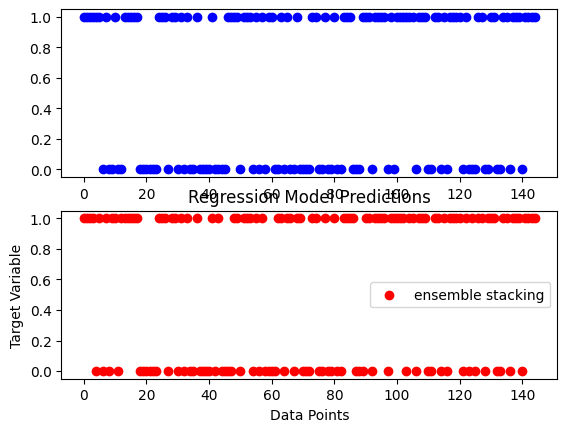

In [305]:
# ========================== Ensemble Learning - stacking =======================================
from mlxtend.classifier import StackingCVClassifier

sclf_model = StackingCVClassifier(classifiers=[knn_model, random_forest_model, XGBoost_model, logistic_regression_model, svm_model, decision_tree_model],
                          meta_classifier=random_forest_model)
execute_model(sclf_model, X_train, Y_train, X_test, Y_test, "ensemble stacking")

## Save the Models

In [306]:
import pickle

In [307]:
filename = 'ms2 model classification.sav'
decision_tree_model.fit(X_train, Y_train)
pickle.dump(decision_tree_model, open(filename, 'wb'))

# Saving Label encoders

In [308]:
pickle.dump(encoders, open("ms2 encoders classification.sav", 'wb'))

# Saving one hot encoder

> Add blockquote



In [309]:
pickle.dump(one_hot_encoders, open("ms2 one hot encoders classification.sav", 'wb'))